In [501]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [502]:
# Зачитываем данные из файлов и, если есть пустые ячейки, то оставить их пустыми, не заполнять Nan

trd = pd.read_csv('train.csv', keep_default_na=False)
tsd = pd.read_csv('test.csv')

# Пример соединения Дата Фреймов в один

td = pd.concat([trd, tsd], ignore_index=True, sort = False)

Text(0.5, 1.0, 'Missing values heatmap')

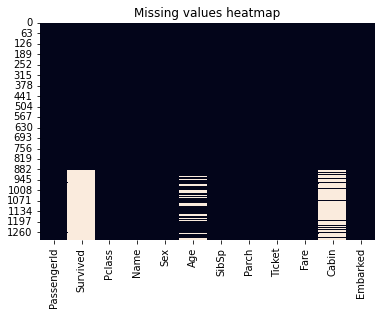

In [503]:
# Проверяем, какие ячейки пустые из объединенных тренировочных данных и тестовых

td.isnull().sum()
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")

In [504]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid', 'High_Mid','High'])

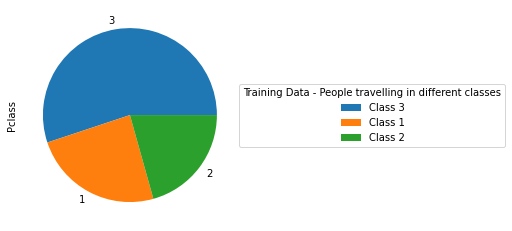

In [505]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Training Data - People travelling in different classes")

In [506]:
print(trd.Pclass.value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64


Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of class')

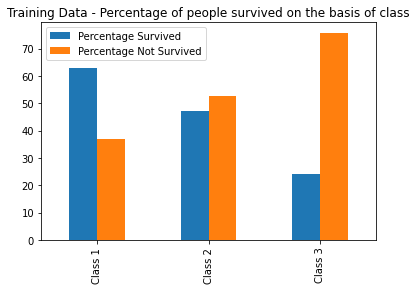

In [507]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Class 1": pclass_1_survivor_distribution,"Class 2": pclass_2_survivor_distribution, "Class 3": pclass_3_survivor_distribution},  
     "Percentage Not Survived":{"Class 1": 100-pclass_1_survivor_distribution,"Class 2": 100-pclass_2_survivor_distribution, "Class 3": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of class")



'With AGE'

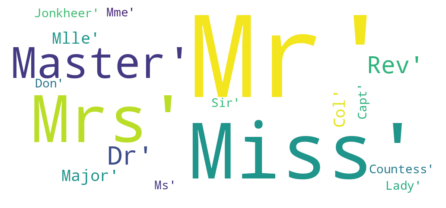

In [508]:
display('With AGE')
trd['Salutation'] = trd.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
trd.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(trd.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

'NO AGE'

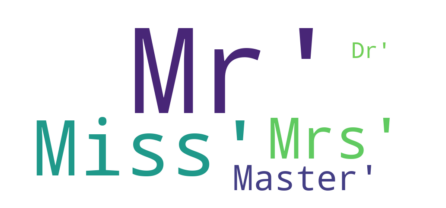

In [509]:
trd_no_age = trd.loc[trd.Age == ""]
trd_with_age = trd.loc[trd.Age != ""]

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display (trd_no_age).Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display (trd_with_age).Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

display("NO AGE")
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(trd_no_age.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [510]:
# Преобразуем пол в 0 и 1

trd['Sex'] = LabelEncoder().fit_transform(trd['Sex'])

In [511]:
# Создаем новую таблицу из одной колонки Embarked, содержащей три значения: S, Q, C. 
# Новая таблица будет из трех колонок: Embarked_S, Embarked_Q, Embarked_C, в которых будут только 0 и 1

emb = pd.get_dummies(trd.Embarked, prefix="Embarked", drop_first = False)

# Добавляем новые колонки из новой таблицы в старую таблицу по одному

trd['Embarked_C'] = emb.Embarked_C
trd['Embarked_Q'] = emb.Embarked_Q
trd['Embarked_S'] = emb.Embarked_S

# Теперь нам больше не нужен Embarked
trd.drop("Embarked", axis=1, inplace=True)

In [512]:
# Тоже самое делаем для классов

pclass = pd.get_dummies(trd.Pclass, prefix="Class", drop_first = False)

trd['Class_1'] = pclass.Class_1
trd['Class_2'] = pclass.Class_2
trd['Class_3'] = pclass.Class_3

# Теперь нам больше не нужен Pclass
trd.drop("Pclass", axis=1, inplace=True)

In [513]:
# Замещаем все пустые ячейки с возрастом у пассажиров с Master в имени

master = trd_with_age[trd_with_age['Salutation'] == "Master"]  
display(master.Age.median())

master_age = master.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Master"), ['Age']] = master_age

#display(trd.loc[trd.Salutation == "Master"])

3.5

In [514]:
# Замещаем все пустые ячейки с возрастом у пассажиров с Mr в имени
mr = trd_with_age[trd_with_age['Salutation'] == "Mr"]  
display(mr.Age.median())
display(trd.loc[(trd.Age == "") & (trd.Salutation == "Mr")])

mr_age = mr.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Mr"), ['Age']] = mr_age

display(trd.loc[trd.Salutation == "Mr"])

30.0

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
5,6,0,"Moran, Mr. James",1,,0,0,330877,8.4583,,Mr,0,1,0,0,0,1
17,18,1,"Williams, Mr. Charles Eugene",1,,0,0,244373,13.0000,,Mr,0,0,1,0,1,0
26,27,0,"Emir, Mr. Farred Chehab",1,,0,0,2631,7.2250,,Mr,1,0,0,0,0,1
29,30,0,"Todoroff, Mr. Lalio",1,,0,0,349216,7.8958,,Mr,0,0,1,0,0,1
36,37,1,"Mamee, Mr. Hanna",1,,0,0,2677,7.2292,,Mr,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,840,1,"Marechal, Mr. Pierre",1,,0,0,11774,29.7000,C47,Mr,1,0,0,1,0,0
846,847,0,"Sage, Mr. Douglas Bullen",1,,8,2,CA. 2343,69.5500,,Mr,0,0,1,0,0,1
859,860,0,"Razi, Mr. Raihed",1,,0,0,2629,7.2292,,Mr,1,0,0,0,0,1
868,869,0,"van Melkebeke, Mr. Philemon",1,,0,0,345777,9.5000,,Mr,0,0,1,0,0,1


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
0,1,0,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,,Mr,0,0,1,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,,Mr,0,0,1,0,0,1
5,6,0,"Moran, Mr. James",1,30,0,0,330877,8.4583,,Mr,0,1,0,0,0,1
6,7,0,"McCarthy, Mr. Timothy J",1,54,0,0,17463,51.8625,E46,Mr,0,0,1,1,0,0
12,13,0,"Saundercock, Mr. William Henry",1,20,0,0,A/5. 2151,8.0500,,Mr,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,882,0,"Markun, Mr. Johann",1,33,0,0,349257,7.8958,,Mr,0,0,1,0,0,1
883,884,0,"Banfield, Mr. Frederick James",1,28,0,0,C.A./SOTON 34068,10.5000,,Mr,0,0,1,0,1,0
884,885,0,"Sutehall, Mr. Henry Jr",1,25,0,0,SOTON/OQ 392076,7.0500,,Mr,0,0,1,0,0,1
889,890,1,"Behr, Mr. Karl Howell",1,26,0,0,111369,30.0000,C148,Mr,1,0,0,1,0,0


In [515]:
# Замещаем все пустые ячейки с возрастом у пассажиров с Miss в имени

miss = trd_with_age[trd_with_age['Salutation'] == "Miss"]  
#display(miss)
display(miss.Age.median())

display(trd.loc[(trd.Age == "") & (trd.Salutation == "Miss")])

miss_age = miss.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Miss"), ['Age']] = miss_age

display(trd.loc[trd.Salutation == "Miss"])

21.0

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
28,29,1,"O'Dwyer, Miss. Ellen ""Nellie""",0,,0,0,330959,7.8792,,Miss,0,1,0,0,0,1
32,33,1,"Glynn, Miss. Mary Agatha",0,,0,0,335677,7.7500,,Miss,0,1,0,0,0,1
47,48,1,"O'Driscoll, Miss. Bridget",0,,0,0,14311,7.7500,,Miss,0,1,0,0,0,1
82,83,1,"McDermott, Miss. Brigdet Delia",0,,0,0,330932,7.7875,,Miss,0,1,0,0,0,1
109,110,1,"Moran, Miss. Bertha",0,,1,0,371110,24.1500,,Miss,0,1,0,0,0,1
128,129,1,"Peter, Miss. Anna",0,,1,1,2668,22.3583,F E69,Miss,1,0,0,0,0,1
180,181,0,"Sage, Miss. Constance Gladys",0,,8,2,CA. 2343,69.5500,,Miss,0,0,1,0,0,1
198,199,1,"Madigan, Miss. Margaret ""Maggie""",0,,0,0,370370,7.7500,,Miss,0,1,0,0,0,1
229,230,0,"Lefebre, Miss. Mathilde",0,,3,1,4133,25.4667,,Miss,0,0,1,0,0,1
235,236,0,"Harknett, Miss. Alice Phoebe",0,,0,0,W./C. 6609,7.5500,,Miss,0,0,1,0,0,1


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
2,3,1,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,,Miss,0,0,1,0,0,1
10,11,1,"Sandstrom, Miss. Marguerite Rut",0,4,1,1,PP 9549,16.7000,G6,Miss,0,0,1,0,0,1
11,12,1,"Bonnell, Miss. Elizabeth",0,58,0,0,113783,26.5500,C103,Miss,0,0,1,1,0,0
14,15,0,"Vestrom, Miss. Hulda Amanda Adolfina",0,14,0,0,350406,7.8542,,Miss,0,0,1,0,0,1
22,23,1,"McGowan, Miss. Anna ""Annie""",0,15,0,0,330923,8.0292,,Miss,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,867,1,"Duran y More, Miss. Asuncion",0,27,1,0,SC/PARIS 2149,13.8583,,Miss,1,0,0,0,1,0
875,876,1,"Najib, Miss. Adele Kiamie ""Jane""",0,15,0,0,2667,7.2250,,Miss,1,0,0,0,0,1
882,883,0,"Dahlberg, Miss. Gerda Ulrika",0,22,0,0,7552,10.5167,,Miss,0,0,1,0,0,1
887,888,1,"Graham, Miss. Margaret Edith",0,19,0,0,112053,30.0000,B42,Miss,0,0,1,1,0,0


In [516]:
mrs = trd_with_age[trd_with_age['Salutation'] == "Mrs"]  
display(mrs.Age.median())

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(trd.loc[(trd.Age == "") & (trd.Salutation == "Mrs")])

mrs_age = mrs.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Mrs"), ['Age']] = mrs_age
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(trd.loc[trd.Salutation == "Mrs"])

35.0

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
19,20,1,"Masselmani, Mrs. Fatima",0,,0,0,2649,7.2250,,Mrs,1,0,0,0,0,1
31,32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",0,,1,0,PC 17569,146.5208,B78,Mrs,1,0,0,1,0,0
140,141,0,"Boulos, Mrs. Joseph (Sultana)",0,,0,2,2678,15.2458,,Mrs,1,0,0,0,0,1
166,167,1,"Chibnall, Mrs. (Edith Martha Bowerman)",0,,0,1,113505,55.0000,E33,Mrs,0,0,1,1,0,0
186,187,1,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",0,,1,0,370365,15.5000,,Mrs,0,1,0,0,0,1
256,257,1,"Thorne, Mrs. Gertrude Maybelle",0,,0,0,PC 17585,79.2000,,Mrs,1,0,0,1,0,0
334,335,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",0,,1,0,PC 17611,133.6500,,Mrs,0,0,1,1,0,0
347,348,1,"Davison, Mrs. Thomas Henry (Mary E Finck)",0,,1,0,386525,16.1000,,Mrs,0,0,1,0,0,1
367,368,1,"Moussa, Mrs. (Mantoura Boulos)",0,,0,0,2626,7.2292,,Mrs,1,0,0,0,0,1
375,376,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",0,,1,0,PC 17604,82.1708,,Mrs,1,0,0,1,0,0


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,Mrs,1,0,0,1,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,Mrs,0,0,1,1,0,0
8,9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27,0,2,347742,11.1333,,Mrs,0,0,1,0,0,1
9,10,1,"Nasser, Mrs. Nicholas (Adele Achem)",0,14,1,0,237736,30.0708,,Mrs,1,0,0,0,1,0
15,16,1,"Hewlett, Mrs. (Mary D Kingcome)",0,55,0,0,248706,16.0000,,Mrs,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",0,47,1,1,11751,52.5542,D35,Mrs,0,0,1,1,0,0
874,875,1,"Abelson, Mrs. Samuel (Hannah Wizosky)",0,28,1,0,P/PP 3381,24.0000,,Mrs,1,0,0,0,1,0
879,880,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",0,56,0,1,11767,83.1583,C50,Mrs,1,0,0,1,0,0
880,881,1,"Shelley, Mrs. William (Imanita Parrish Hall)",0,25,0,1,230433,26.0000,,Mrs,0,0,1,0,1,0


In [517]:
doctor = trd_with_age[trd_with_age['Salutation'] == "Dr"]  
display(doctor.Age.median())

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(trd.loc[(trd.Age == "") & (trd.Salutation == "Dr")])

doctor_age = doctor.Age.median()

trd.loc[(trd.Age == "") & (trd.Salutation == "Dr"), ['Age']] = doctor_age
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
display(trd.loc[trd.Salutation == "Dr"])

46.5

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
766,767,0,"Brewe, Dr. Arthur Jackson",1,,0,0,112379,39.6,,Dr,1,0,0,1,0,0


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Salutation,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3
245,246,0,"Minahan, Dr. William Edward",1,44,2,0,19928,90.0000,C78,Dr,0,1,0,1,0,0
317,318,0,"Moraweck, Dr. Ernest",1,54,0,0,29011,14.0000,,Dr,0,0,1,0,1,0
398,399,0,"Pain, Dr. Alfred",1,23,0,0,244278,10.5000,,Dr,0,0,1,0,1,0
632,633,1,"Stahelin-Maeglin, Dr. Max",1,32,0,0,13214,30.5000,B50,Dr,1,0,0,1,0,0
660,661,1,"Frauenthal, Dr. Henry William",1,50,2,0,PC 17611,133.6500,,Dr,0,0,1,1,0,0
766,767,0,"Brewe, Dr. Arthur Jackson",1,46.5,0,0,112379,39.6000,,Dr,1,0,0,1,0,0
796,797,1,"Leader, Dr. Alice (Farnham)",0,49,0,0,17465,25.9292,D17,Dr,0,0,1,1,0,0


In [539]:
df = trd.copy(deep=True)
# Номер кабины нужен?
df.drop("Cabin", axis=1, inplace=True)
# Номер билета?
df.drop("Ticket", axis=1, inplace=True)
df.drop("Name", axis=1, inplace=True)
df.drop("Salutation", axis=1, inplace=True)
df.drop("PassengerId", axis=1, inplace=True)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#display (df)

cols = df.columns.tolist()
print(cols)   

cols = [cols[0]] + cols[2:] + [cols[1]]

df = df[cols]
print(cols)   

display (df)

dataForNeural = [
    trd['Class_1'],
    trd['Class_2'],
    trd['Class_3'], 
    trd['Sex'],
    trd['Sex'],
    trd['Age'],
    trd['SibSp'],
    trd['Parch'],
    trd['Embarked_S'],
    trd['Embarked_C'],
    trd['Embarked_Q'],
    trd.Survived
]


['PassengerId', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Class_1', 'Class_2', 'Class_3']
['PassengerId', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Class_1', 'Class_2', 'Class_3', 'Survived']


,PassengerId,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Class_1,Class_2,Class_3,Survived
0,1,1,22,1,0,7.2500,0,0,1,0,0,1,0
1,2,0,38,1,0,71.2833,1,0,0,1,0,0,1
2,3,0,26,0,0,7.9250,0,0,1,0,0,1,1
3,4,0,35,1,0,53.1000,0,0,1,1,0,0,1
4,5,1,35,0,0,8.0500,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,27,0,0,13.0000,0,0,1,0,1,0,0
887,888,0,19,0,0,30.0000,0,0,1,1,0,0,1
888,889,0,21,1,2,23.4500,0,0,1,0,0,1,0
889,890,1,26,0,0,30.0000,1,0,0,1,0,0,1


In [ ]:
dataForNeural = []

In [ ]:
print(dataForNeural)

In [ ]:
#results = model.fit( trd, epochs = 3,  batch_size = 500, validation_data = tsd)